# Libnflation

A quick example notebook for the inflation lib, a library to solve optimization problems with causal constraints. 
Still work in progress.

In [1]:
import sympy as sp
import numpy as np
import ncpol2sdpa as nc
from itertools import zip_longest
from libinflation import *

# Generate DAGs

## Generate base DAG

We start by defining a causal DAG.
The node labels can be chosen between strings and sympy objects. 
Obviovsly strings will be pretty useless for most of the operations we want to do on DAGs, maybe we should just remove this possibility.
Internally they are stored as directed graphs using the **graph-tool** library, but the `CausalDAG` class should provide a nice interface to
most operations you want to perform on them, using the labels as indices.

For instance the following function is to automate the creation of a triangle scenario with arbitrary number of settings, using sympy `HermitianOperator` objects as node labels for observable variables, and plain sympy `Symbol`s for latent ones.

In [2]:
def triangle_dag(*settings):
    C = nc.physics_utils.Correlators(*settings)
    λs = sp.symbols('Λ1,Λ2,Λ3') 
    g = CausalDAG()
    for obs in C.parties:
        g.add_node(obs)
    for i, λ in enumerate(λs):
        g.add_node(λ, latent=True)
        n1, n2 = C.parties[i:i+2] if i < len(C.parties)-1 else (C.parties[-1], C.parties[0])
        g.add_link(λ, n1[0])
        g.add_link(λ, n2[0])
    return g, C

For example, with no settings:

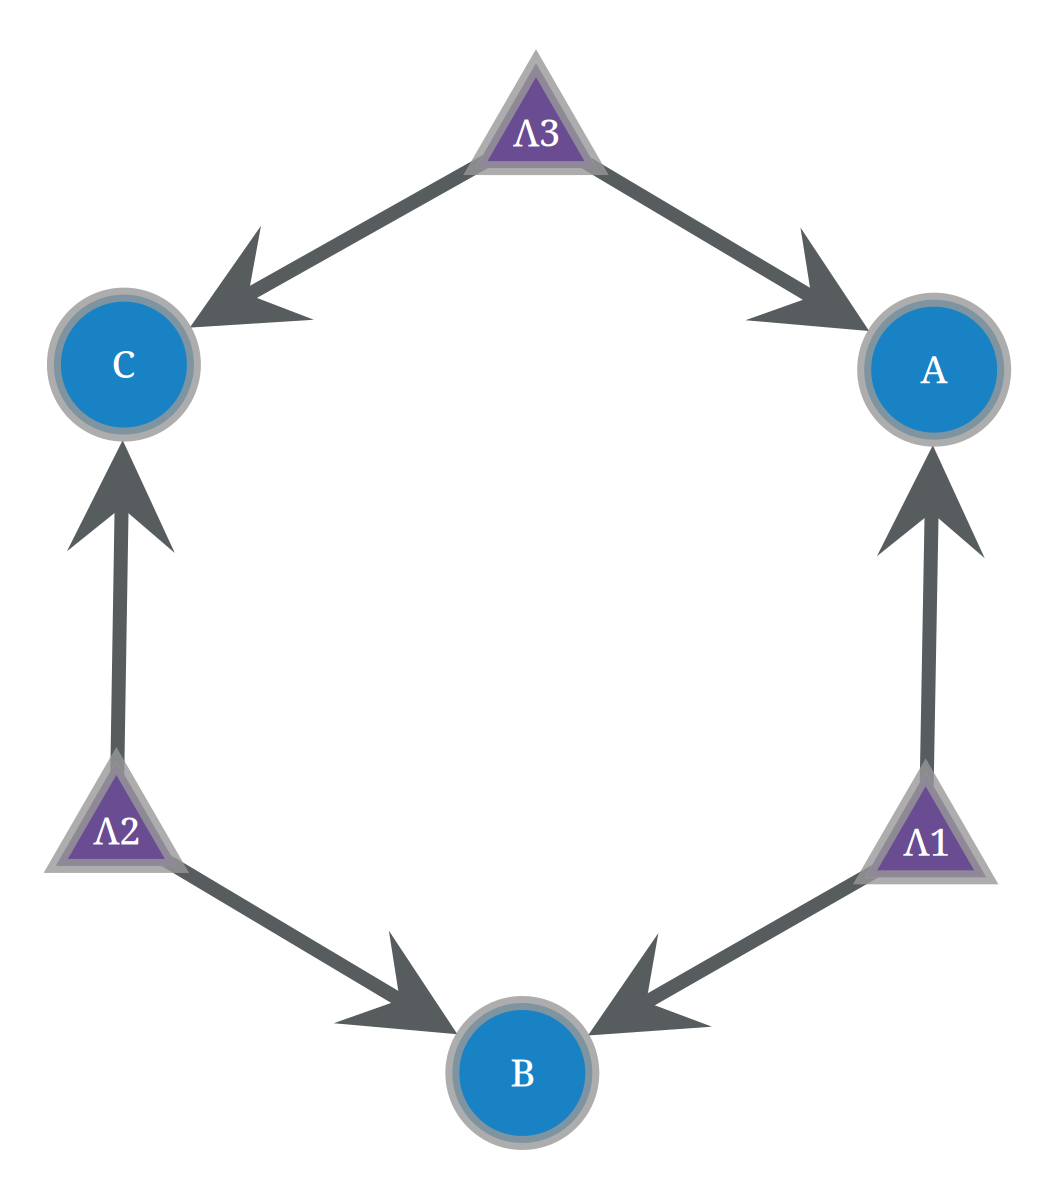

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdaea8f1db0, at 0x7fdaea8f16c0>

In [3]:
bg1, symcorr1 = triangle_dag(1,1,1)
bg1.draw()

Or with $2$ settings for each variable:

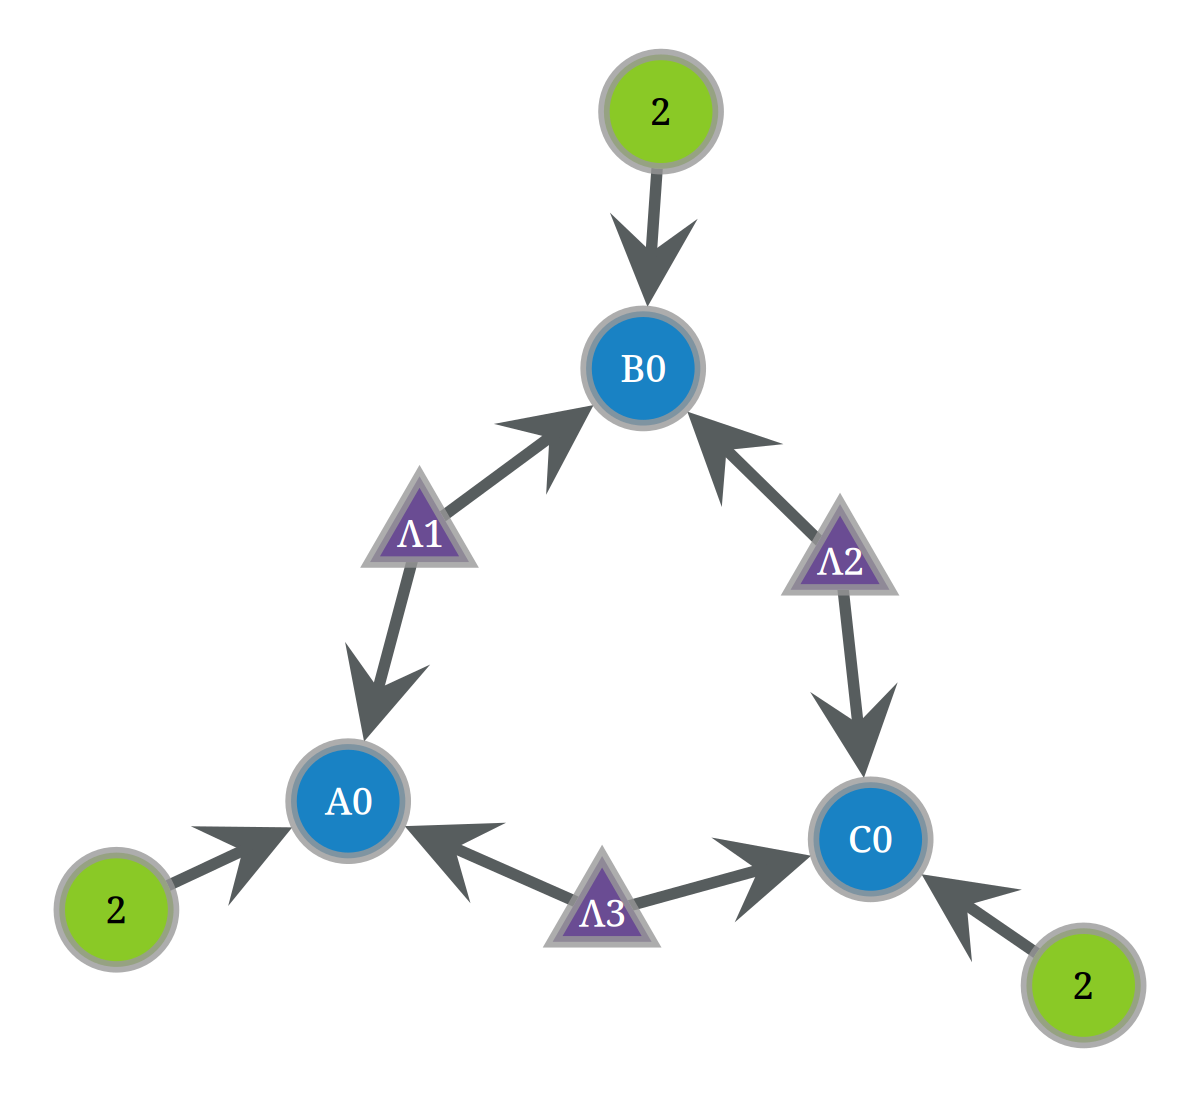

<VertexPropertyMap object with value type 'vector<double>', for a non-existent graph, at 0x7fdaea954730>

In [4]:
bg2, symcorr2 = triangle_dag(2,2,2)
bg2.draw()

**Technical note**: Despite the representation, settings (or exogenous variables in general) 
are not stored as nodes in the internal graph of the DAG object. 
Instead they associate more than one symbol to the same node, this is why in the drawing the nodes are called $A_0, B_0, C_0$ instead of just $A, B, C$: the label comes from the first symbol of the set.

## Generate inflation DAG

Inflations can be created from two basic operation:

1. `duplicate_node`: which creates a copy-index node with the parents of the original one.
2. `switch parent`: which switches the tail of an incoming edge from a copy index node to another copy of one of its parents.

A third operation exists to _undo_ the duplication:

3. `merge_nodes`: which merges two copies of the same base node.

As an example on how to build and inflation the following function automates the generation of a "chain-cut" inflation on the triangle scenario, given the total number `K` of the inflated nodes.

In [5]:
def generate_linecut_inflation(K, base_graph):
    
    ig = Inflation(base_graph)
    obs = list(ig.dag.get_nodes())
    lat = list(ig.dag.get_nodes(node_type='latent'))
    N = len(lat) # nobs + 1
    if K < N: raise ValueError("I hate you.")
    
    λlast = ig.duplicate_node(lat[-1])[0]
    pre_λ = λlast
    for i in range(N, K):
        λ = ig.duplicate_node(lat[i % N])[0]
        o = ig.duplicate_node(obs[i % N])[0]
        ig.switch_parent(o, lat[i % N], λ)
        ig.switch_parent(o, lat[(i % N) - 1], pre_λ)
    
        pre_λ = λ
        
    ig.switch_parent(obs[-1], lat[-1], λlast)
    return ig

Example of a chain with $5$ total nodes.

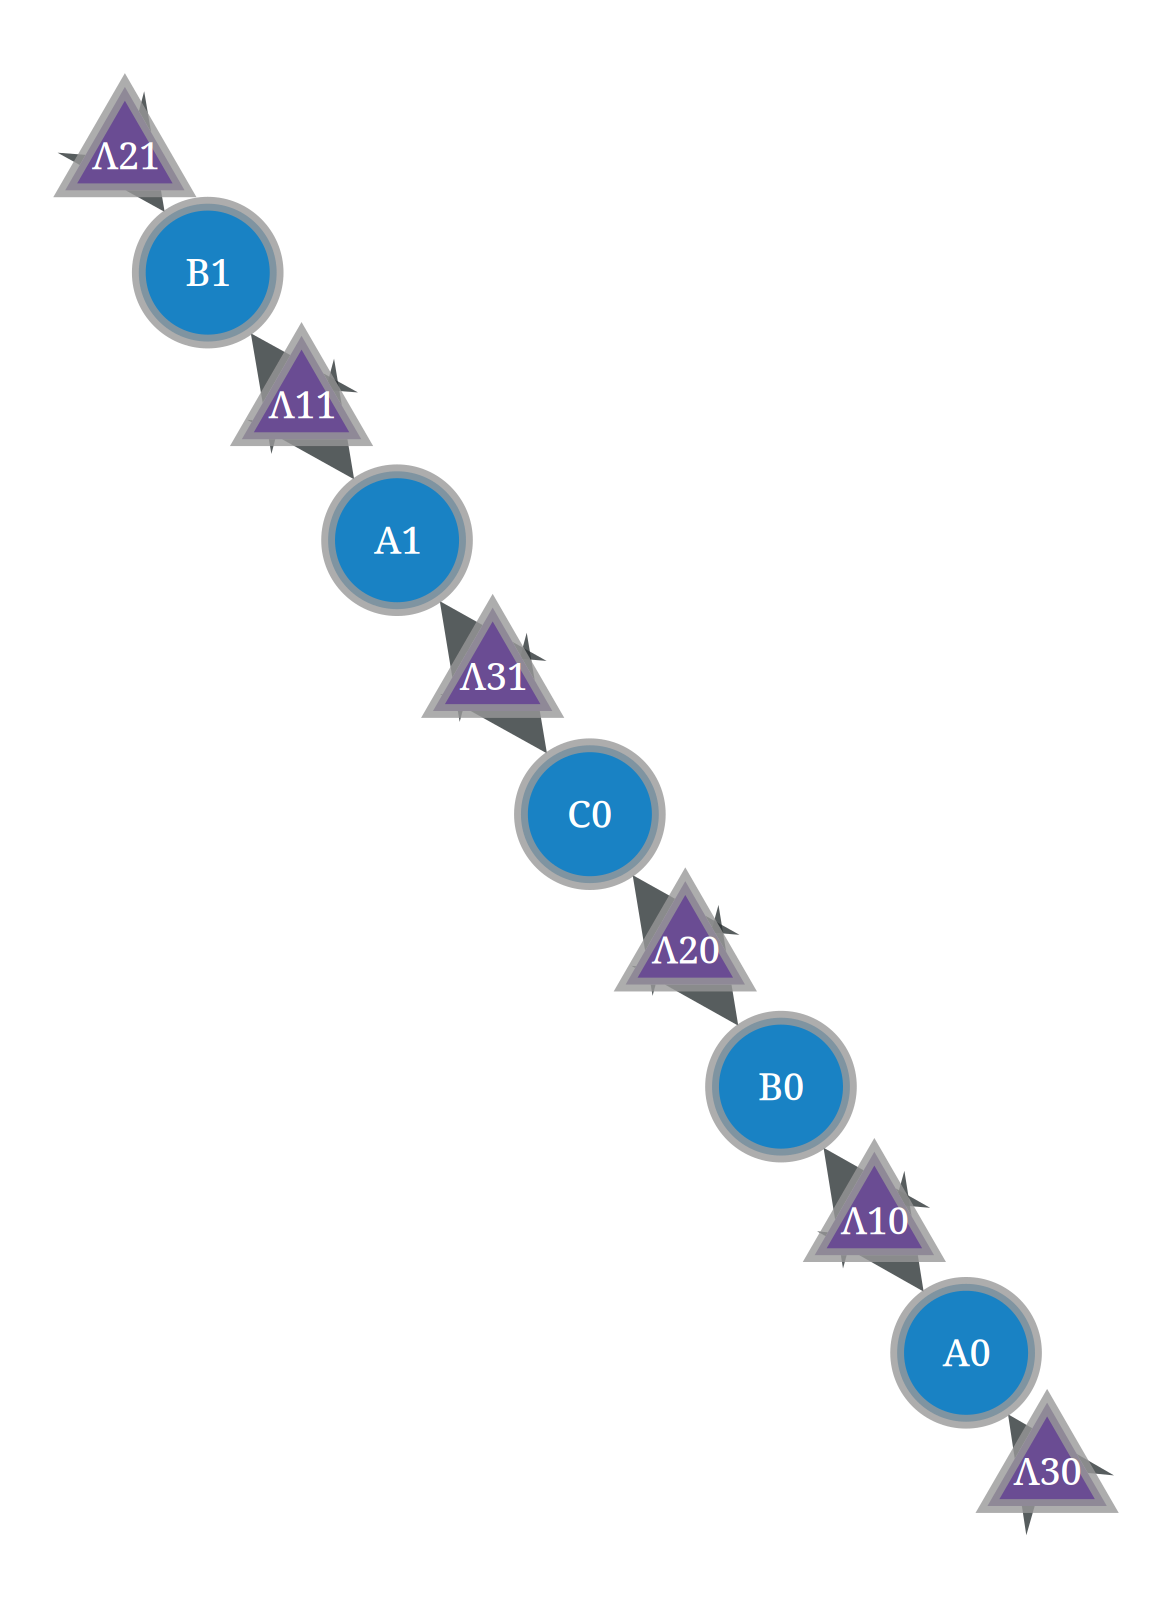

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdaea8f36a0, at 0x7fdaea956890>

In [6]:
ig = generate_linecut_inflation(5, bg1)
ig.dag.draw(output_size=(800, 800))

## Graph operations

There are a few computations that can be performed on the DAGs, besides the trivial ones of getting parents, childrens, ancestors, descendants we can
for example check for **d-separation** between two nodes.

Below we check if the **d-separation** between the nodes of the chain DAG above is the one we expect.

In [7]:
# Quick check
obs = list(ig.dag.get_nodes())
for i, o1 in enumerate(obs):
    for j, o2 in enumerate(obs[i+1:]):
        assert (ig.dag.d_separated(o1, o2) or j == 0)

Using this, the DAG class builds a "dependency graph" storing the separation relations between the nodes, which is useful to do operations as splitting a set of symbols in d-separated subsets, implmented by the method `d-split`.
This method is used below to properly evaluate a give probability distribution for arbitrary expressions, taking into account the factorization properties and injectability given by an Inflation.

# Probability evaluation

We can evaluate a give probability distribution for an arbitrary sympy expression, considering the factorization properties and injectability defined by and inflation.
To do this we can define a distribution using the object `Correlations`, by giving as input a numpy array defining the distribution numerically, and a set of symbols, identifying the axis of the array with the nodes of the DAG.

For the triangle scenario without inputs, we can define the _W-distribution_ as:

In [8]:
pW = np.fromfunction(lambda a,b,c: 1/3*(a+c+b == 1), shape=(2,2,2))
λ = .9
prob = pW*λ + (1-λ)/8

In [9]:
a,b,c = bg1.get_nodes()
a,b,c

(A, B, C)

In [10]:
corr_DAG = DAGDistribution(prob, [a,b,c], bg1)

In [11]:
a*b

A*B

We can directly evaluates the distribution with the `eval` method. This obviously puts no constraints and just evaluate the corresponding sympy expression

In [12]:
corr_DAG.eval(a*b)

-0.30000000000000004

Alternatively we can evaluate the distribution on a specific inflation DAG.
To do this we use `eval_inflation` which takes an expression, a distribution (`Correlations` object) and an `Inflation` object.

In the following cell we get the basic symbols to build expression and then we check the evaluation for different cases.

In [13]:
iobs = list(ig.dag.get_nodes())
A, B, C = zip_longest(*[iobs[3*i:3*(i+1)] for i in range(len(iobs)//3 +1)])

# We can also use an external variable, the evaluation should just ignore this
α = sp.var('α')

A,B,C

((A0, A1), (B0, B1), (C0, None))

Injectable, completely evaluable

In [14]:
corr = InflatedDistribution(corr_DAG, ig)

In [ ]:
corr.eval(A[0]*B[0])

-0.30000000000000004

Non-injectable, leave symbolic expression

In [19]:
corr.eval(A[0]*B[0]*C[0])

A0*B0*C0

Separably injectable, completely evaluable

In [26]:
corr.eval(A[1]*A[0])

0.09000000000000001

Separably injectable, partially evaluable

In [ ]:
eval_inflation(A[1]*B[1]*C[0]*A[0], corr, ig)

Separably injectable, partially evaluable, with an external variable

In [ ]:
eval_inflation(A[1]*B[1]*C[0]*A[0]*α, corr, ig)

# Distribution feasibility check

To test a distribution against a particular causal model we use the class `NPAFeasibilityProblem`.
This class creates an instance of such a problem for a given DAG or inflation, for a certain level of the NPA hierarchy, using the **ncpol2sdpa** library.

The scalar extension technique is also implemented internally.
To use it we just need to specify a set of symbols that we want to associate with an extension variable in the `scalar_extension` parameter.
We can also put `"all"` on that parameter to let the code automagically find the minimum set of nodes to associate to extension variables to enforce all the separability relationships between moment.
Alternatively we can set the parameter to an integer `n < level` to tell the routine to consider moments only up to a certain degree.

Below we test the feasibility of the previously created _W-distribution_ on the chain cut inflation of the triangle, letting the code define the extension variables.

In [ ]:
p = NPAFeasibilityProblem(ig, corr, 
                             level=4,
                             scalar_extension="all", 
                             substitutions=symcorr1.substitutions, 
                             #solver='cvxopt',
)

This defines the problem, to solve it just run

In [ ]:
p.solve(verbose=True)

## Binary search

As an appication of the above here a snippet to perform a binary search for the maximum $\lambda$ allowed in a noisy _W-distribution_ on the triangle scenario.

In [ ]:
a,b,c = bg1.get_nodes()
#ig = generate_linecut_inflation(5, bg)
λmin, λmax = (0,1)
corr = Correlations(pW, [a,b,c])
p = NPAFeasibilityProblem(ig, corr, 
                     level=3,
                     scalar_extension=True, 
                     substitutions=symcorr.substitutions)
for k in range(7):
    λ = (λmax + λmin)/2
    corr = Correlations(pW*λ + (1-λ)/8, [a,b,c])
    p.correlations = corr
    print(f"\rInterval:[{λmin}, {λmax}], trying λ = {λ}...", end="")
    feasible = p.solve(verbose=False)
    if feasible:
        λmin = λ
    else: 
        λmax = λ
        
print(f"{(λmax + λmin)/2} +- {(λmax - λmin)/2}")